<a href="https://colab.research.google.com/github/babi2707/Trabalho-PAI---Reconhecimento-Papanicolau/blob/main/algoritmo/backend/RedeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Célula 1:
import zipfile

caminho_pasta_compactada = '/content/sub_images.zip'
caminho_destino = '/content/sub_images'

with zipfile.ZipFile(caminho_pasta_compactada, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

In [14]:
# Célula 2:
import os

base_dir = '/content/sub_images/sub_images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

In [15]:
# Célula 3:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import numpy as np
from imblearn.over_sampling import SMOTE
import cv2

# Diretório onde estão os dados
data_dir = '/content/sub_images/sub_images'

# Lista para armazenar os nomes dos arquivos e suas respectivas classes
file_names = []
labels = []

# Preencher as listas com os nomes dos arquivos e suas classes correspondentes
classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']  # Adicionar os nomes das classes
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        file_names.append(file_path)
        labels.append(class_name)

# Dividir os dados em treino e teste mantendo a proporção de 4:1
train_files, test_files, train_labels, test_labels = train_test_split(
    file_names, labels, test_size=0.2, random_state=42, stratify=labels)

# Função para extrair características de histograma de cor
def extract_histogram_features(image_path, h_bins=16, s_bins=8):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extrair características das imagens de treino
train_features = [extract_histogram_features(file_path) for file_path in train_files]

# Aplicar oversampling no conjunto de treino
smote = SMOTE(random_state=42)
train_features, train_labels = smote.fit_resample(np.array(train_features), train_labels)

# Verificar o balanceamento das classes nos conjuntos de treino e teste
unique, counts = np.unique(train_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de treino:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

# Balancear o conjunto de testes via oversampling
balanced_test_files = []
balanced_test_labels = []

# Encontrar a classe majoritária no conjunto de teste
max_test_class_count = max([test_labels.count(c) for c in set(test_labels)])

# Aplicar oversampling em cada classe no conjunto de teste
for class_name in set(test_labels):
    class_test_files = [file for file, label in zip(test_files, test_labels) if label == class_name]
    class_test_labels = [label for label in test_labels if label == class_name]

    # Oversampling
    if len(class_test_files) < max_test_class_count:
        class_test_files, class_test_labels = resample(
            class_test_files, class_test_labels, replace=True, n_samples=max_test_class_count, random_state=42)

    balanced_test_files.extend(class_test_files)
    balanced_test_labels.extend(class_test_labels)

# Verificar o balanceamento das classes no conjunto de teste balanceado
unique, counts = np.unique(balanced_test_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de teste balanceado:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

Balanceamento das classes no conjunto de treino:
Classe ASC-H: 3395 amostras
Classe ASC-US: 3395 amostras
Classe HSIL: 3395 amostras
Classe LSIL: 3395 amostras
Classe Negative for intraepithelial lesion: 3395 amostras
Classe SCC: 3395 amostras
Balanceamento das classes no conjunto de teste balanceado:
Classe ASC-H: 849 amostras
Classe ASC-US: 849 amostras
Classe HSIL: 849 amostras
Classe LSIL: 849 amostras
Classe Negative for intraepithelial lesion: 849 amostras
Classe SCC: 849 amostras


In [16]:
# Célula 4:
import shutil
import os

def split_data(source_dir, train_dir, test_dir):
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            if image_path in train_files:
                dest_path = os.path.join(train_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(train_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)
            elif image_path in balanced_test_files:
                dest_path = os.path.join(test_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(test_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)

split_data(data_dir, train_dir, test_dir)

In [18]:
# Célula 5.1 - SVM - Binary
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib

# Preparar rótulos binários (0 para 'Negative', 1 para 'Others')
binary_labels_train = np.where(np.array(train_labels) == 'Negative for intraepithelial lesion', 0, 1)
binary_labels_test = np.where(np.array(balanced_test_labels) == 'Negative for intraepithelial lesion', 0, 1)

# Normalização das características de treino e teste
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform([extract_histogram_features(file_path) for file_path in balanced_test_files])

# Treinamento do classificador binário
svm_binary = SVC(kernel='linear')
svm_binary.fit(train_features_scaled, binary_labels_train)

# Previsões do classificador binário
binary_predictions = svm_binary.predict(test_features_scaled)

# Salvar o modelo binário usando joblib
joblib.dump(svm_binary, 'svm_binary_model.pkl')

['svm_binary_model.pkl']

In [19]:
# Célula 5.2 - SVM:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib
import h5py

def extract_histogram_features(image_path, h_bins=16, s_bins=8):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

train_features = []
train_labels_hist = []
test_features = []
test_labels_hist = []

for file_path, label in zip(train_files, train_labels):
    features = extract_histogram_features(file_path)
    train_features.append(features)
    train_labels_hist.append(label)

for file_path, label in zip(balanced_test_files, balanced_test_labels):
    features = extract_histogram_features(file_path)
    test_features.append(features)
    test_labels_hist.append(label)

train_features = np.array(train_features)
test_features = np.array(test_features)

# Codificar as classes
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_hist)
test_labels_encoded = label_encoder.transform(test_labels_hist)

# Padronizar as características
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

svm_model = SVC(kernel='linear')
svm_model.fit(train_features_scaled, train_labels_encoded)

# Salvar o modelo usando joblib
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

In [7]:
# Célula 5.3 - Resnet50:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

# Parameters
img_height, img_width = 100, 100
batch_size = 32
num_classes = 6
class_names = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']

# Data augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurar checkpoint para salvar apenas o melhor modelo
checkpoint_callback = ModelCheckpoint(
    filepath='/content/modelo_resnet50.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=80,  # Ajuste conforme necessário
    callbacks=[checkpoint_callback]
)

# Carregar o melhor modelo salvo durante o treinamento
best_model = tf.keras.models.load_model('/content/modelo_resnet50.h5')

# Avaliar no conjunto de teste
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Salvar o modelo final
best_model.save('/content/modelo_resnet50_final.h5')

Found 4464 images belonging to 6 classes.
Found 1117 images belonging to 6 classes.
Found 1117 images belonging to 6 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/80
140/140 [==============================] - ETA: 0s - loss: 2.7559 - accuracy: 0.1662

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 32s 164ms/step - loss: 2.7559 - accuracy: 0.1662 - val_loss: 3.0107 - val_accuracy: 0.0519
Epoch 2/80
140/140 [==============================] - 21s 152ms/step - loss: 2.6326 - accuracy: 0.2375 - val_loss: 2.8277 - val_accuracy: 0.0868
Epoch 3/80
140/140 [==============================] - 31s 221ms/step - loss: 2.5586 - accuracy: 0.3033 - val_loss: 2.4327 - val_accuracy: 0.1110
Epoch 4/80
140/140 [==============================] - 21s 153ms/step - loss: 2.4843 - accuracy: 0.3259 - val_loss: 2.0420 - val_accuracy: 0.6580
Epoch 5/80
140/140 [==============================] - 20s 143ms/step - loss: 2.4152 - accuracy: 0.3280 - val_loss: 1.8786 - val_accuracy: 0.6822
Epoch 6/80
140/140 [==============================] - 21s 152ms/step - loss: 2.3435 - accuracy: 0.3620 - val_loss: 1.7640 - val_accuracy: 0.7090
Epoch 7/80
140/140 [==============================] - 21s 146ms/step - loss: 2.2749 - accuracy: 0.3882 - val_loss: 1.7443 - val_accuracy: 0.7

In [9]:
# Célula 5.4 - Resnet50 (Binary Classifier):

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Parameters
img_height, img_width = 100, 100
batch_size = 32
num_classes = 2

# Data augmentation
datagen_train_bin = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val_test_bin = ImageDataGenerator(rescale=1./255)

# Definir classes para mapeamento
class_mapping = {'Negative for intraepithelial lesion': 'Negative',
                 'ASC-H': 'Others',
                 'ASC-US': 'Others',
                 'HSIL': 'Others',
                 'LSIL': 'Others',
                 'SCC': 'Others'}

# Função para carregar dados e aplicar o mapeamento de classes
def load_data_generator(directory, data_generator, target_size, batch_size, class_mode):
    return data_generator.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        classes=class_mapping.keys(),  # Especificar as classes mapeadas
        seed=42
    )

# Ajuste dos geradores de dados
train_generator_bin = load_data_generator(train_dir, datagen_train_bin, (img_height, img_width), batch_size, 'binary')
val_generator_bin = load_data_generator(test_dir, datagen_val_test_bin, (img_height, img_width), batch_size, 'binary')
test_generator_bin = load_data_generator(test_dir, datagen_val_test_bin, (img_height, img_width), batch_size, 'binary')

# Model
base_model_bin = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model_bin.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions_bin = Dense(1, activation='sigmoid')(x)  # Saída com sigmoid para classificação binária

model_bin = Model(inputs=base_model_bin.input, outputs=predictions_bin)

for layer in base_model_bin.layers:
    layer.trainable = False

# Compilar e treinar o modelo binário
model_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',  # Usar binary_crossentropy para classificação binária
                  metrics=['accuracy', 'binary_accuracy'])  # Métricas para classificação binária

# Definir o callback ModelCheckpoint para salvar o melhor modelo
checkpoint_filepath = '/content/modelo_resnet50_binary_best.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_binary_accuracy',  # Monitorar a métrica de acurácia binária
    mode='max',
    save_best_only=True
)

# Treinamento do modelo
history_bin = model_bin.fit(
    train_generator_bin,
    steps_per_epoch=len(train_generator_bin),
    validation_data=val_generator_bin,
    validation_steps=len(val_generator_bin),
    epochs=30,
    callbacks=[model_checkpoint_callback]
)

# Avaliar o modelo binário
test_loss_bin, test_acc_bin, test_binary_acc_bin = model_bin.evaluate(test_generator_bin)

# Previsões no conjunto de teste binário
predictions_bin = model_bin.predict(test_generator_bin)
predicted_classes_bin = np.where(predictions_bin > 0.5, 1, 0)  # Convertendo probabilidades para classes binárias

true_classes_bin = test_generator_bin.classes

# Métricas de avaliação
binary_accuracy_bin = accuracy_score(true_classes_bin, predicted_classes_bin)
conf_matrix_bin = confusion_matrix(true_classes_bin, predicted_classes_bin)
classification_report_bin = classification_report(true_classes_bin, predicted_classes_bin)

print(f'Binary ResNet50 Classifier Accuracy: {binary_accuracy_bin}')
print('Binary ResNet50 Classifier Confusion Matrix:')
print(conf_matrix_bin)
print('Binary ResNet50 Classifier Classification Report:')
print(classification_report_bin)

# Carregar o melhor modelo salvo durante o treinamento
model_bin.load_weights(checkpoint_filepath)

# Salvar o modelo final
model_bin.save('/content/modelo_resnet50_binary.h5')

Found 4464 images belonging to 6 classes.
Found 1117 images belonging to 6 classes.
Found 1117 images belonging to 6 classes.
Epoch 1/30
140/140 [==============================] - 27s 159ms/step - loss: 1.1595 - accuracy: 0.4541 - binary_accuracy: 0.4541 - val_loss: 1.0155 - val_accuracy: 0.0152 - val_binary_accuracy: 0.0152
Epoch 2/30
140/140 [==============================] - 20s 143ms/step - loss: 0.7815 - accuracy: 0.3965 - binary_accuracy: 0.3965 - val_loss: 0.9610 - val_accuracy: 0.0152 - val_binary_accuracy: 0.0152
Epoch 3/30
140/140 [==============================] - 22s 156ms/step - loss: 0.5491 - accuracy: 0.3822 - binary_accuracy: 0.3822 - val_loss: 0.6640 - val_accuracy: 0.0179 - val_binary_accuracy: 0.0179
Epoch 4/30
140/140 [==============================] - 21s 150ms/step - loss: 0.4061 - accuracy: 0.3772 - binary_accuracy: 0.3772 - val_loss: 3.2631 - val_accuracy: 0.7440 - val_binary_accuracy: 0.7440
Epoch 5/30
140/140 [==============================] - 19s 139ms/step -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/trainin

In [21]:
#Célula 6.1 - Avaliação dos SVM:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Carregar o modelo SVM binário
svm_binary = joblib.load('svm_binary_model.pkl')

# Carregar o modelo SVM multiclasse (supondo que você já tenha treinado e salvo este modelo)
svm_multiclass = joblib.load('svm_model.pkl')

# Previsões do classificador binário
binary_predictions = svm_binary.predict(test_features_scaled)

# Previsões do classificador multiclasse
multiclass_predictions = svm_multiclass.predict(test_features_scaled)

# Avaliação do classificador binário
binary_accuracy = accuracy_score(binary_labels_test, binary_predictions)
binary_conf_matrix = confusion_matrix(binary_labels_test, binary_predictions)
print('Binary Classifier Accuracy:', binary_accuracy)
print('Binary Classifier Confusion Matrix:')
print(binary_conf_matrix)
print('Binary Classifier Classification Report:')
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))

# Avaliação do classificador multiclasse
multiclass_accuracy = accuracy_score(test_labels_encoded, multiclass_predictions)
multiclass_conf_matrix = confusion_matrix(test_labels_encoded, multiclass_predictions)
print('Multiclass Classifier Accuracy:', multiclass_accuracy)
print('Multiclass Classifier Confusion Matrix:')
print(multiclass_conf_matrix)
print('Multiclass Classifier Classification Report:')
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))

Binary Classifier Accuracy: 0.8286219081272085
Binary Classifier Confusion Matrix:
[[  51  798]
 [  75 4170]]
Binary Classifier Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.06      0.10       849
      Others       0.84      0.98      0.91      4245

    accuracy                           0.83      5094
   macro avg       0.62      0.52      0.50      5094
weighted avg       0.77      0.83      0.77      5094

Multiclass Classifier Accuracy: 0.36670592854338435
Multiclass Classifier Confusion Matrix:
[[332   0  55   0 411  51]
 [  0   0  56   0 783  10]
 [ 62  21 426  24 282  34]
 [  4  15   8  23 792   7]
 [  5   1  11   4 828   0]
 [  0   0 265  59 266 259]]
Multiclass Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.82      0.39      0.53       849
                             ASC-US       0.00      0.00      0.00 

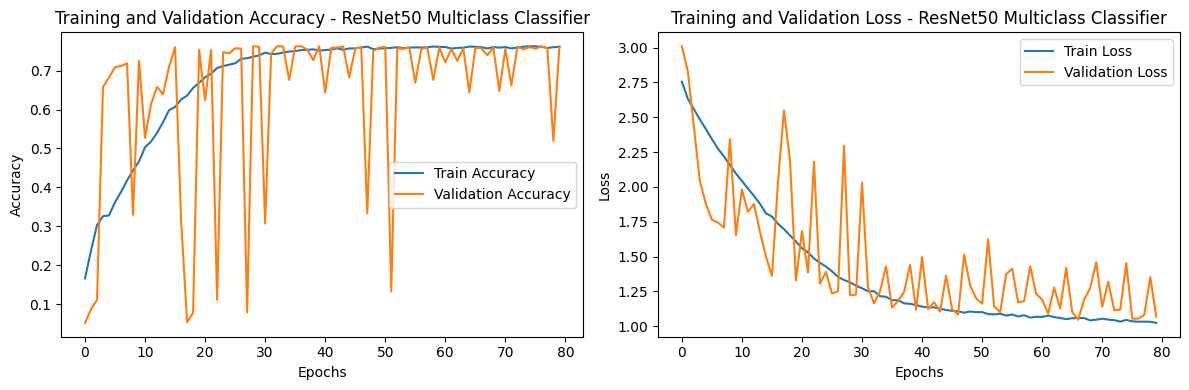

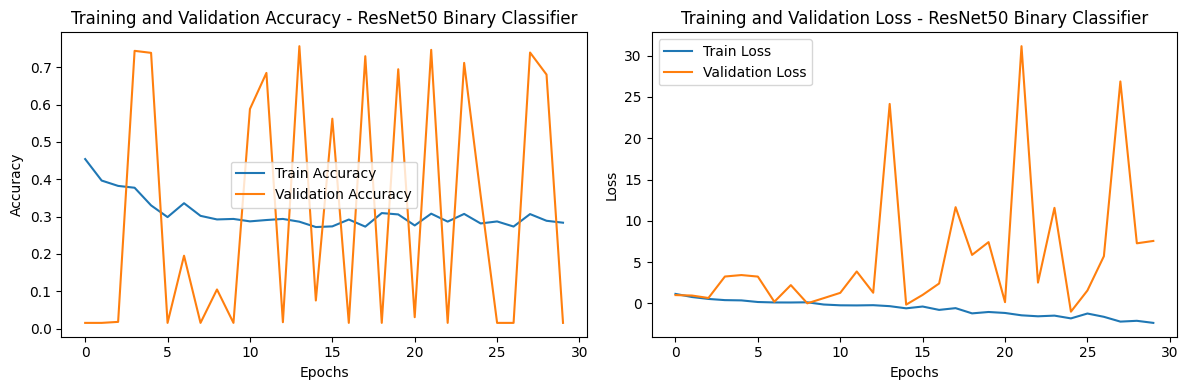

In [22]:
#Célula 6.2 - Curvas de Aprendizado Resnet50:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import math  # Importar o módulo math

# Função para plotar gráfico de aprendizado
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy - {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar curvas de aprendizado para modelo multiclasse
plot_learning_curves(history, title='ResNet50 Multiclass Classifier')

# Plotar curvas de aprendizado para modelo binário
plot_learning_curves(history_bin, title='ResNet50 Binary Classifier')

In [27]:
# Célula 7 - Comparação dos Resultados ResNet50:

# Previsões no conjunto de teste para ResNet50
test_steps_per_epoch_resnet = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions_resnet = best_model.predict(test_generator, steps=test_steps_per_epoch_resnet)
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)

# True labels para ResNet50
true_classes_resnet = test_generator.classes
class_labels_resnet = list(test_generator.class_indices.keys())

# Acurácia e relatório de classificação para ResNet50
accuracy_resnet = accuracy_score(true_classes_resnet, predicted_classes_resnet)
conf_matrix_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)
classification_report_resnet = classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels_resnet)

print(f'ResNet50 Classifier Accuracy: {accuracy_resnet}')
print('ResNet50 Classifier Confusion Matrix:')
print(conf_matrix_resnet)
print('ResNet50 Classifier Classification Report:')
print(classification_report_resnet)

<ipython-input-27-474790cb847c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch_resnet = np.math.ceil(test_generator.samples / test_generator.batch_size)


35/35 [==============================] - 5s 74ms/step
ResNet50 Classifier Accuracy: 0.7529095792300806
ResNet50 Classifier Confusion Matrix:
[[  0   0   0   0  17   0]
 [  0   0   1   0  77   0]
 [  0   0   0   0  58   0]
 [  0   0   2   0  97   0]
 [  0   0   8   0 841   0]
 [  0   0   0   0  16   0]]
ResNet50 Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.00      0.00      0.00        17
                             ASC-US       0.00      0.00      0.00        78
                               HSIL       0.00      0.00      0.00        58
                               LSIL       0.00      0.00      0.00        99
Negative for intraepithelial lesion       0.76      0.99      0.86       849
                                SCC       0.00      0.00      0.00        16

                           accuracy                           0.75      1117
                          macro avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Célula 8 - Comparação 4 modelos:

# Acurácia e relatório de classificação para ResNet50 Binary Classifier
test_steps_per_epoch_bin = np.math.ceil(test_generator_bin.samples / test_generator_bin.batch_size)
predictions_bin = model_bin.predict(test_generator_bin, steps=test_steps_per_epoch_bin)
predicted_classes_bin = np.where(predictions_bin > 0.5, 1, 0)  # Convertendo probabilidades para classes binárias

true_classes_bin = test_generator_bin.classes
class_labels_bin = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']

# Acurácia e relatório de classificação para ResNet50 Binary Classifier
accuracy_bin = accuracy_score(true_classes_bin, predicted_classes_bin)
conf_matrix_bin = confusion_matrix(true_classes_bin, predicted_classes_bin)
classification_report_bin = classification_report(true_classes_bin, predicted_classes_bin, target_names=class_labels_bin)

print(f'ResNet50 Binary Classifier Accuracy: {accuracy_bin}')
print('ResNet50 Binary Classifier Confusion Matrix:')
print(conf_matrix_bin)
print('ResNet50 Binary Classifier Classification Report:')
print(classification_report_bin)

# Comparação de Acurácia
print("==== Comparação de Acurácia ====")
print(f'SVM Binary Classifier Accuracy: {binary_accuracy}')
print(f'SVM Multiclass Classifier Accuracy: {multiclass_accuracy}')
print(f'ResNet50 Classifier Accuracy: {accuracy_resnet}')
print(f'ResNet50 Binary Classifier Accuracy: {accuracy_bin}')

# Comparação de Matrizes de Confusão
print("\n==== Matrizes de Confusão ====")
print("SVM Binary Classifier Confusion Matrix:")
print(binary_conf_matrix)
print("\nSVM Multiclass Classifier Confusion Matrix:")
print(multiclass_conf_matrix)
print("\nResNet50 Classifier Confusion Matrix:")
print(conf_matrix_resnet)
print("\nResNet50 Binary Classifier Confusion Matrix:")
print(conf_matrix_bin)

# Comparação de Relatórios de Classificação
print("\n==== Relatórios de Classificação ====")
print("SVM Binary Classifier Classification Report:")
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))
print("\nSVM Multiclass Classifier Classification Report:")
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))
print("\nResNet50 Classifier Classification Report:")
print(classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels_resnet))
print("\nResNet50 Binary Classifier Classification Report:")
print(classification_report(true_classes_bin, predicted_classes_bin, target_names=class_labels_bin))

<ipython-input-28-a3fdb795b829>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch_bin = np.math.ceil(test_generator_bin.samples / test_generator_bin.batch_size)


35/35 [==============================] - 2s 51ms/step
ResNet50 Binary Classifier Accuracy: 0.7511190689346464
ResNet50 Binary Classifier Confusion Matrix:
[[839  10   0   0   0   0]
 [ 17   0   0   0   0   0]
 [ 76   2   0   0   0   0]
 [ 58   0   0   0   0   0]
 [ 98   1   0   0   0   0]
 [ 16   0   0   0   0   0]]
ResNet50 Binary Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.76      0.99      0.86       849
                             ASC-US       0.00      0.00      0.00        17
                               HSIL       0.00      0.00      0.00        78
                               LSIL       0.00      0.00      0.00        58
Negative for intraepithelial lesion       0.00      0.00      0.00        99
                                SCC       0.00      0.00      0.00        16

                           accuracy                           0.75      1117
              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<ipython-input-30-6c05be824cbd>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


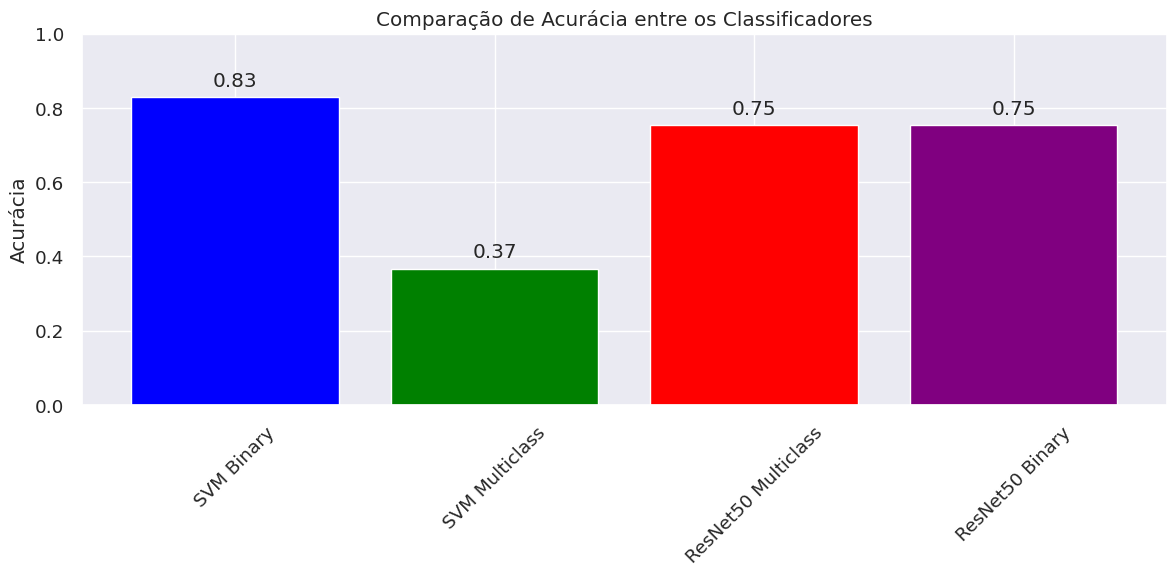

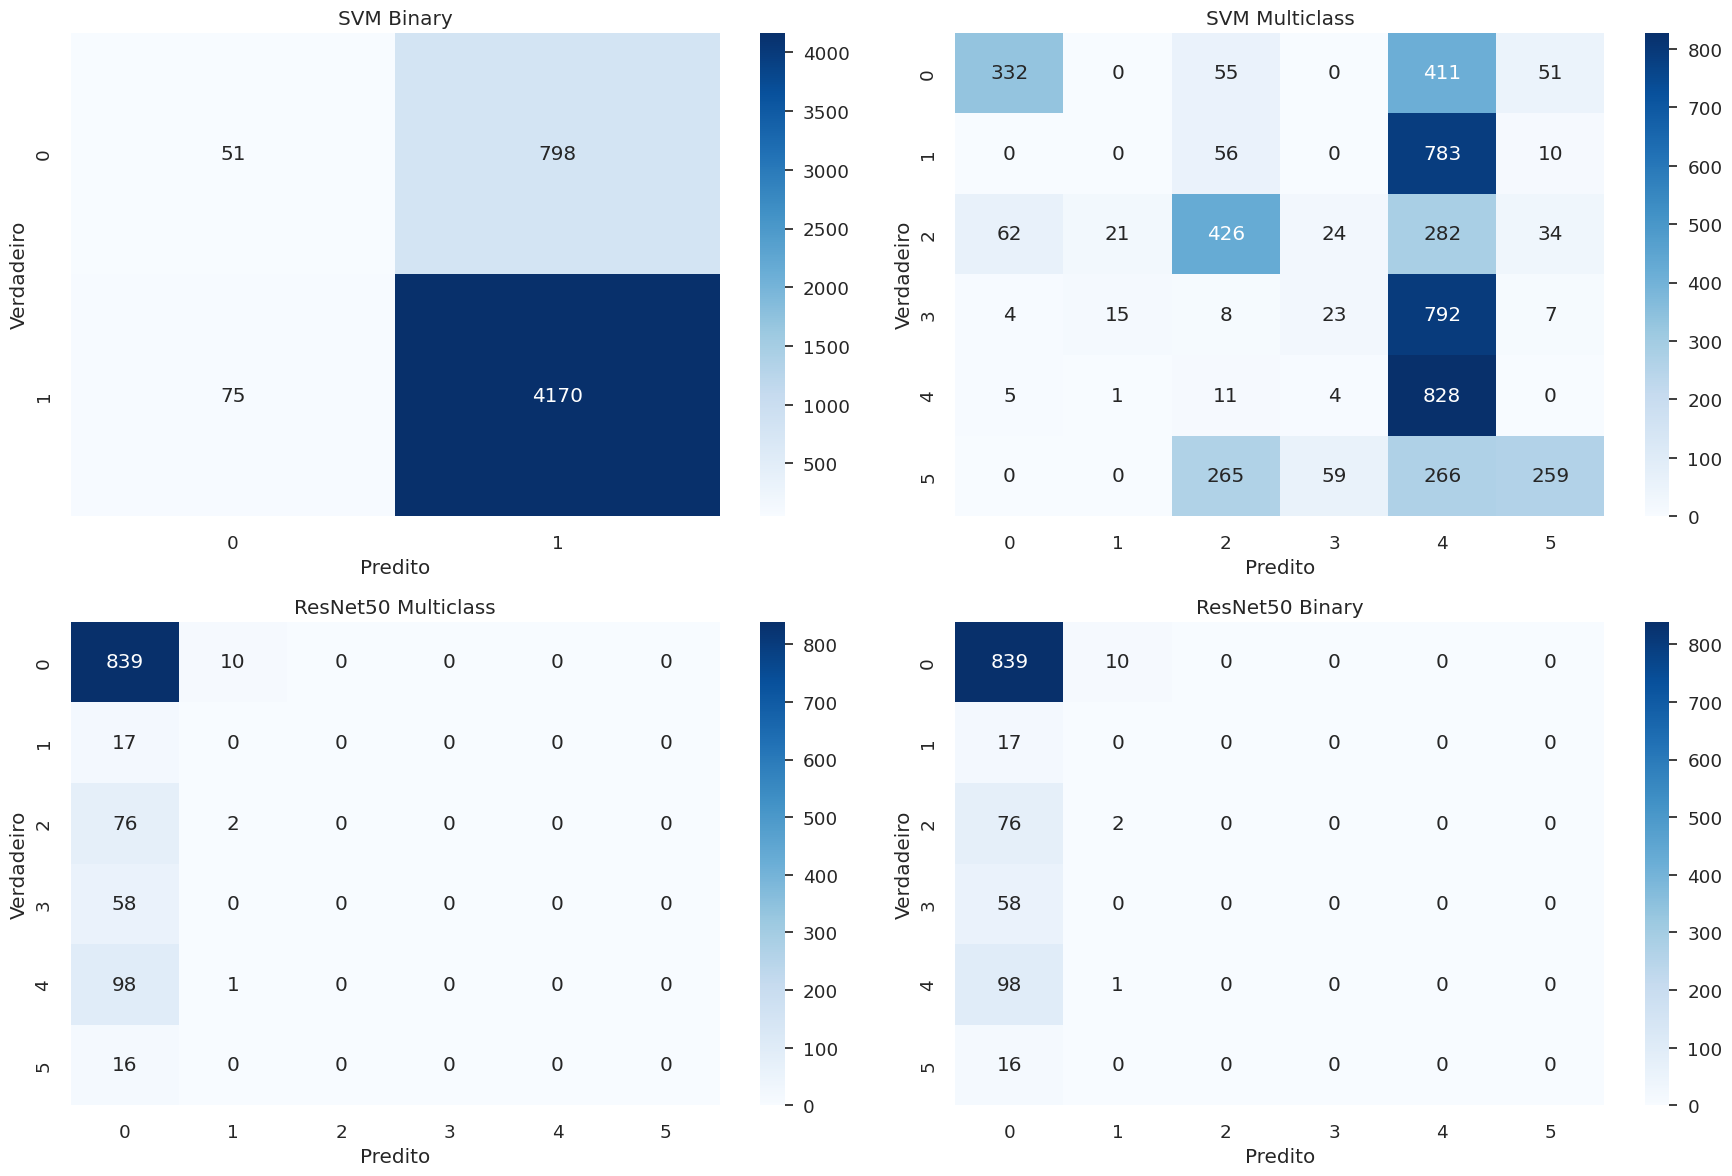

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


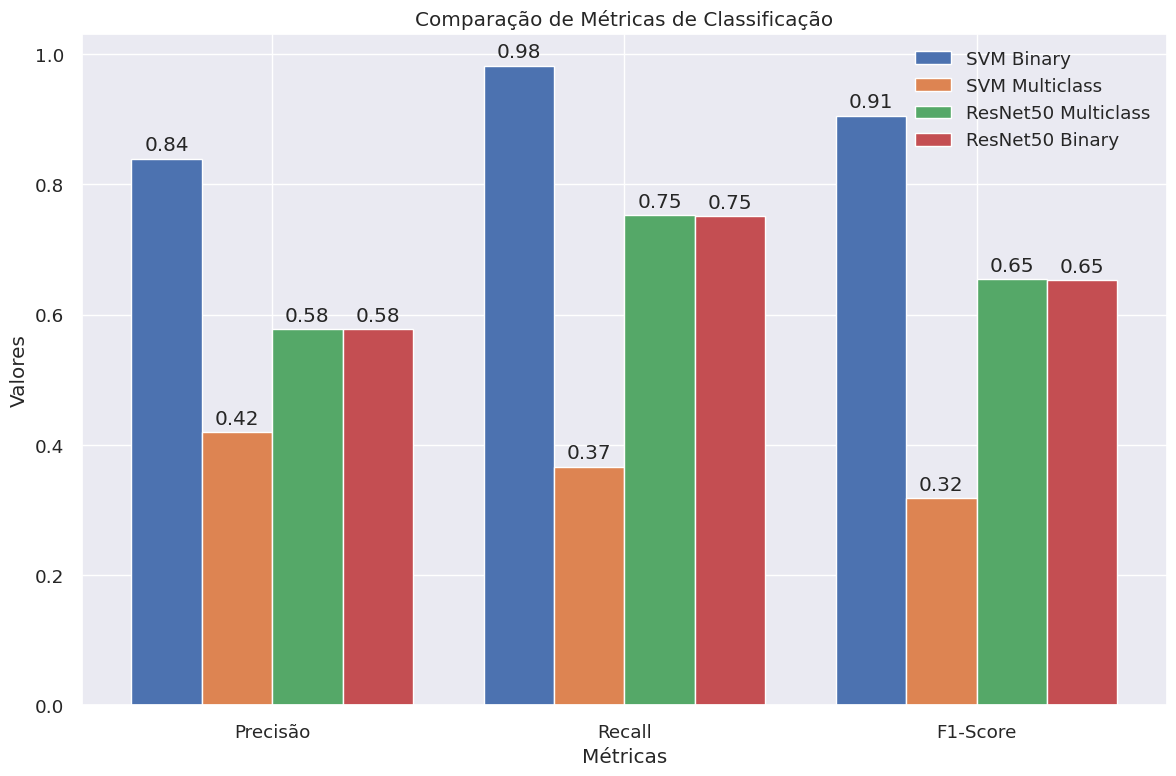

In [30]:
# Célula 8.2 - Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support  # Importar a função necessária

# Configurações gerais para os gráficos
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# 1. Gráfico de Barras para Acurácia
accuracies = [binary_accuracy, multiclass_accuracy, accuracy, accuracy_resnet]
models = ['SVM Binary', 'SVM Multiclass', 'ResNet50 Multiclass', 'ResNet50 Binary']

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre os Classificadores')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Heatmaps para Matrizes de Confusão
conf_matrices = [binary_conf_matrix, multiclass_conf_matrix, conf_matrix, conf_matrix_bin]
titles = ['SVM Binary', 'SVM Multiclass', 'ResNet50 Multiclass', 'ResNet50 Binary']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for ax, conf_matrix, title in zip(axes, conf_matrices, titles):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

# 3. Gráficos de Barras para Métricas de Classificação
# Métricas de classificação: precisão, recall, F1-score
binary_metrics = precision_recall_fscore_support(binary_labels_test, binary_predictions, average='binary')[:3]
multiclass_metrics = precision_recall_fscore_support(test_labels_encoded, multiclass_predictions, average='weighted')[:3]
resnet_metrics = precision_recall_fscore_support(true_classes_resnet, predicted_classes_resnet, average='weighted')[:3]
resnet_bin_metrics = precision_recall_fscore_support(true_classes_bin, predicted_classes_bin, average='weighted')[:3]

metrics = ['Precisão', 'Recall', 'F1-Score']
binary_values = [binary_metrics[0], binary_metrics[1], binary_metrics[2]]
multiclass_values = [multiclass_metrics[0], multiclass_metrics[1], multiclass_metrics[2]]
resnet_values = [resnet_metrics[0], resnet_metrics[1], resnet_metrics[2]]
resnet_bin_values = [resnet_bin_metrics[0], resnet_bin_metrics[1], resnet_bin_metrics[2]]

x = np.arange(len(metrics))  # localização dos rótulos
width = 0.2  # largura das barras

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 1.5*width, binary_values, width, label='SVM Binary')
rects2 = ax.bar(x - 0.5*width, multiclass_values, width, label='SVM Multiclass')
rects3 = ax.bar(x + 0.5*width, resnet_values, width, label='ResNet50 Multiclass')
rects4 = ax.bar(x + 1.5*width, resnet_bin_values, width, label='ResNet50 Binary')

# Adicionar texto para os rótulos
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas de Classificação')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    """Anexa um rótulo de texto acima de cada barra, exibindo seu valor."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()